In [2]:
import quandl
quandl.ApiConfig.api_key = "1VS8Ys2-9xQMfabc_KfS"

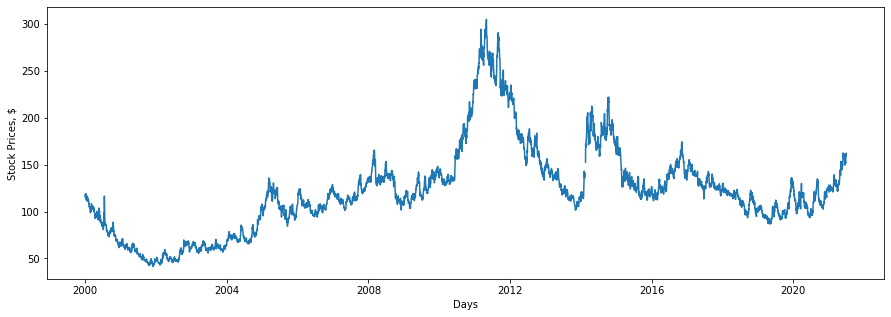

In [3]:

import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

stock_name = 'CHRIS/ICE_KC'

# Plot of E.ON(a big scale energy company in Europe) 
#stock prices since beginning of 2019 (up to July)

prices = quandl.get("CHRIS/ICE_KC1", start_date='2000-01-01', 
                    end_date='2021-07-31').reset_index(drop = False)[['Date', 'Settle']]

plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Settle'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, $')
plt.show()



In [4]:
prices.tail

<bound method NDFrame.tail of            Date  Settle
0    2000-01-03  116.50
1    2000-01-04  116.25
2    2000-01-05  118.60
3    2000-01-06  116.85
4    2000-01-07  114.15
...         ...     ...
5295 2021-06-23  153.15
5296 2021-06-24  152.40
5297 2021-06-25  157.25
5298 2021-06-28  162.25
5299 2021-06-29  159.70

[5300 rows x 2 columns]>

In [8]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

In [9]:
start_date = '2019-07-01'
end_date = '2019-07-31'
pred_end_date = '2019-08-31'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get("CHRIS/ICE_KC1", start_date='2019-01-01', 
                    end_date='2019-07-31').reset_index(drop = False)[['Date', 'Settle']]
print(S_eon.head())
print(S_eon.tail())



        Date  Settle
0 2019-01-02   99.50
1 2019-01-03  102.15
2 2019-01-04  101.60
3 2019-01-07  102.75
4 2019-01-08  105.05
          Date  Settle
143 2019-07-25  100.65
144 2019-07-26   99.75
145 2019-07-29  101.15
146 2019-07-30   99.50
147 2019-07-31   99.65


In [10]:
returns = (S_eon.loc[1:, 'Settle'] - \
           S_eon.shift(1).loc[1:, 'Settle']) / \
           S_eon.shift(1).loc[1:, 'Settle']
print(returns.tolist())

# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Settle"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)



[0.026633165829145787, -0.0053842388644151865, 0.011318897637795332, 0.022384428223844254, 0.002379819133745835, -0.009971509971509945, -0.0038369304556355463, -0.010592200288878136, -0.014111922141119249, 0.010858835143139275, 0.0, 0.024902343749999972, -0.015245354930919566, 0.00048379293662323533, 0.018375241779497016, 0.014245014245014245, -0.038857677902621644, -0.0004870920603995262, -0.004873294346978558, 0.037218413320274354, -0.020774315391879156, 0.018322082931533187, -0.007102272727272728, 0.006199332379589945, -0.011374407582938416, -0.01629913710450626, -0.023391812865496995, 0.00249500998003992, -0.015430562468889967, -0.010616784630940459, 0.0010219724067451052, -0.007656967840735069, 0.0036008230452674313, -0.01486417221937471, 0.0036420395421436894, -0.0005184033177812043, -0.02956431535269718, 0.022982362373062594, -0.00522466039707419, 0.01838235294117647, -0.029396596183599882, 0.02497343251859733, -0.009849663037843471, -0.01937172774869104, 0.01761879337960482, -0

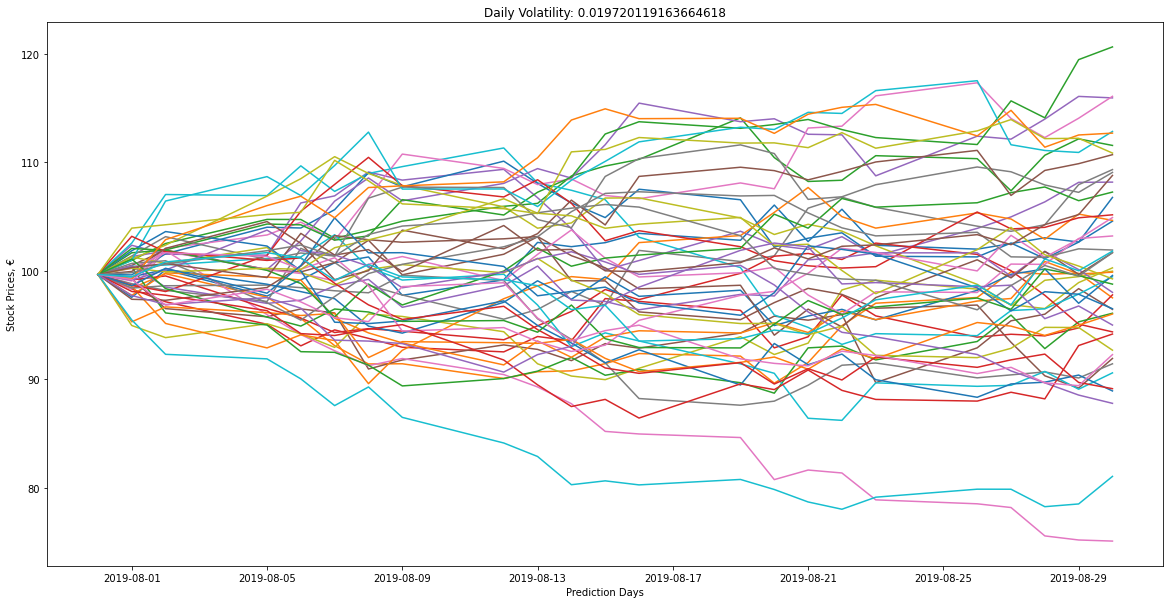

In [11]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)